### MELD

In this notebook we'll merge results from the two techniques used to collect metadata from the phot archive

- **metadata** extraction with exiftool
- **ocr** with tessaract

We'll discuss what we obtained and we'll eventually merge the data to obtain the final dataset

In [58]:
import os
import pandas as pd
import numpy as np

from PIL import Image

In [59]:
datasets_directory = '../datasets'

df_ocr = pd.read_csv(f'{datasets_directory}/ocr.csv', index_col=0)
df_metadata = pd.read_csv(f'{datasets_directory}/metadata.csv', index_col=0)

In [60]:
print('Dataframe without OCR')
print(df_metadata.info())

Dataframe without OCR
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16874 entries, 0 to 16873
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hash        16874 non-null  object
 1   image_name  16874 non-null  object
 2   camera      12422 non-null  object
 3   date_time   16771 non-null  object
 4   date        16771 non-null  object
 5   time        16771 non-null  object
 6   moon        16771 non-null  object
dtypes: object(7)
memory usage: 1.0+ MB
None


In [61]:
print('Dataframe with OCR')
print(df_ocr.info())

Dataframe with OCR
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16874 entries, 0 to 16873
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  16874 non-null  object
 1   camera      16337 non-null  object
 2   date_time   16771 non-null  object
 3   date        16862 non-null  object
 4   time        16862 non-null  object
 5   moon        16771 non-null  object
dtypes: object(6)
memory usage: 922.8+ KB
None


Now we keep going with the dataframe from the ocr process because it is the extension of the metadata one.

We have to remove the duplicate images using the hash we calculated previously

In [66]:
df_ocr.drop_duplicates(subset=['hash'], keep='first', inplace=True)
print(df_ocr.shape)

KeyError: Index(['hash'], dtype='object')

In [67]:
df_ocr.isnull().sum()

image_name      0
camera        537
date_time     103
date           12
time           12
moon          103
dtype: int64

We have to check the results obtained with ocr and metadata combined choose wether to keep or not the data interpreted

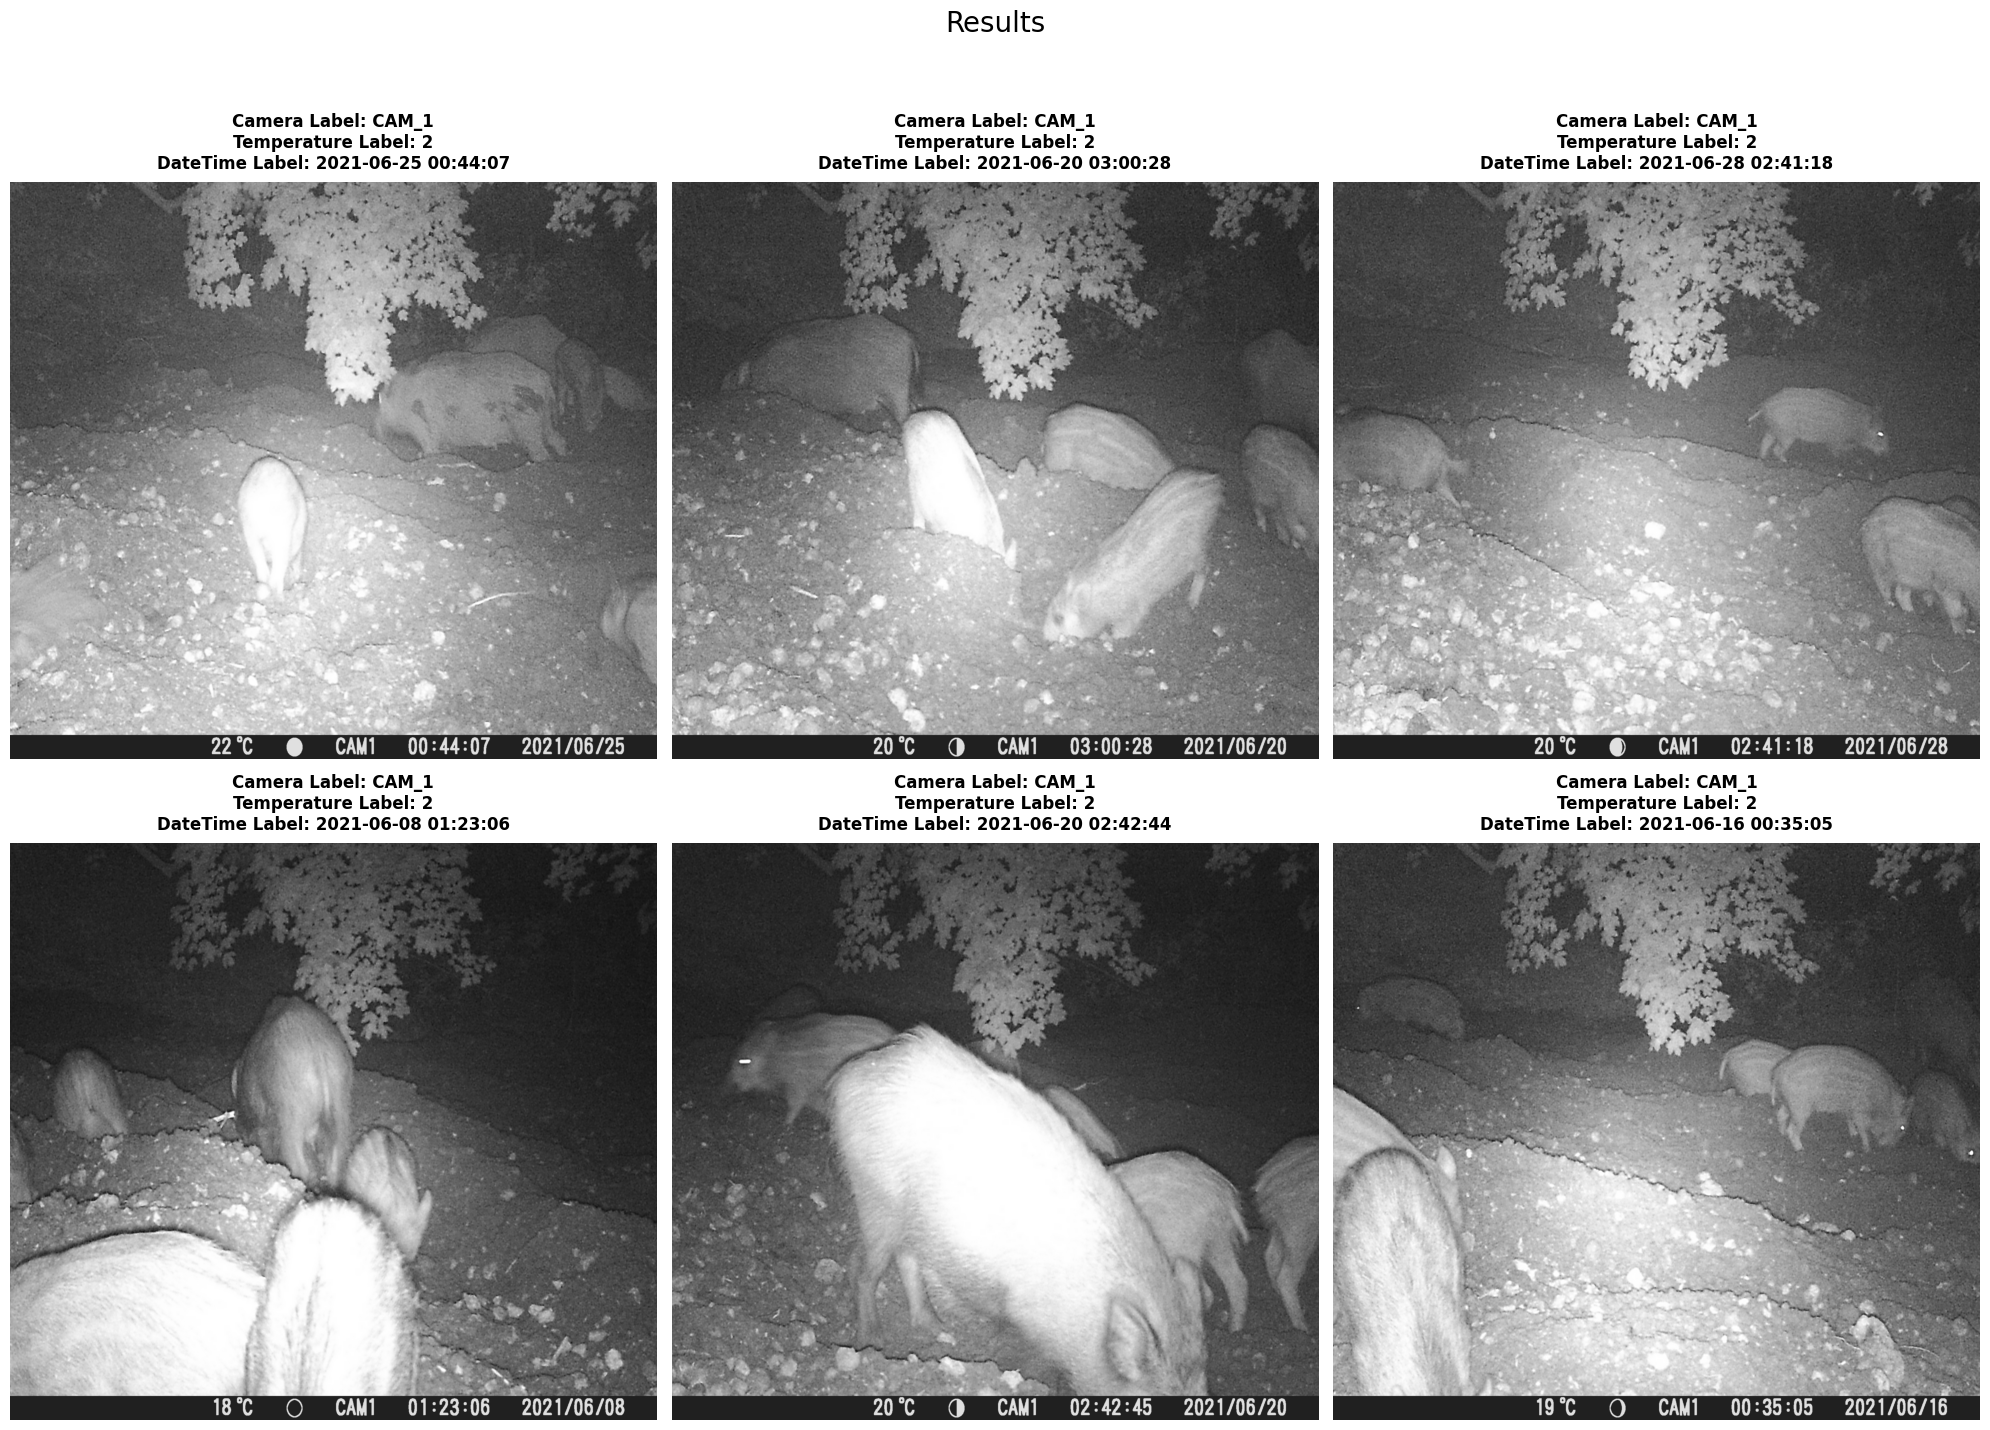

In [86]:
import matplotlib.pyplot as plt
import random

image_folder_path = '../images/aculei-images/'

# valid_rows = df_ocr.dropna(subset=['camera', 'temp', 'date_time'])
valid_rows = df_ocr.dropna(subset=['camera', 'date_time'])
six_random_rows = valid_rows.sample(n=6, random_state=random.seed())
image_folder_path = '../images/aculei-images/'

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Results', fontsize=20)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    
for i, ax in enumerate(axes):
    image_path = os.path.join(image_folder_path, six_random_rows.iloc[i]['image_name'])
    image = Image.open(image_path)
    ax.imshow(image, aspect='auto')
    ax.axis('off')

    camera_info = six_random_rows.iloc[i]['camera']
    date_time_info = six_random_rows.iloc[i]['date_time']
    # temp_info = six_random_rows.iloc[i]['temp'] 
    temp_info = '2'  # You can change this to the actual temp_info

    title_text = f"Camera Label: {camera_info}\nTemperature Label: {temp_info}\nDateTime Label: {date_time_info}"
    ax.set_title(title_text, fontsize=12, fontweight='bold', pad=10)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [68]:
datasets_directory = '../datasets'
df = df_ocr.copy()
df.to_csv(datasets_directory + '/aculei.csv')